<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/EfficientNet_single_crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Evaluator**

In [20]:
import os
import random
import glob
import torch
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, model, classes, val_folder_path, val_transform, device, print_round_num=2) -> None:
        super().__init__()
        self.model = model
        self.val_folder_path = val_folder_path
        self.val_transform = val_transform
        self.device = device
        self.print_round_num = print_round_num

        self.class_names = classes
        self.image_paths = glob.glob(self.val_folder_path + "/*/*")
        print('eval number of classes: ' +str(len(self.class_names)))
        print('eval number of images: ' +str(len(self.image_paths)))
        random.shuffle(self.image_paths) 

        self.max_accuracy = 0
        # to update self.max_accuracy
        self.evaluate()
        print("initial accuracy: " + str(self.max_accuracy))

    def evaluate(self):
        TP = FP = TN = FN = TP = FP = TN = FN = 0
        image_name_list = []
        label_list = []
        model_pred_list = []

        model_pred_class = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label = self.get_label(image_path)
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                          
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob, pred = torch.topk(torch.nn.Softmax(dim=1)(output), 1)
            model_pred = self.class_names[pred]
            #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
            prob = abs(1-float(prob)-float(pred))
            
            image_name_list.append(image_name)
            label_list.append(label)
            model_pred_list.append(model_pred)

            model_pred_class.append(int(pred))
            model_pred_prob.append(float(prob))

            if label == self.class_names[0]:
                if model_pred == self.class_names[0]:
                    TN += 1
                else:
                    FP += 1
            elif label == self.class_names[1]:
                if model_pred == self.class_names[1]:
                    TP += 1
                else:
                    FN += 1

        accuracy, precision, recall, specificity, f_value = self.calculate_accuracy(TP, TN, FP, FN)
        is_best = self.max_accuracy < accuracy
        if is_best:
            self.max_accuracy = accuracy

        return is_best, (round(accuracy, self.print_round_num), 
            round(precision, self.print_round_num), 
            round(recall, self.print_round_num), 
            round(specificity, self.print_round_num), 
            round(f_value, self.print_round_num))
        
    def draw_roc(self, output_path):
        label_list = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label = self.get_label(image_path)
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob, pred = torch.topk(torch.nn.Softmax(dim=1)(output), 1)
            #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
            prob = abs(1-float(prob)-float(pred))

            label_list.append(label)
            model_pred_prob.append(float(prob))

        y_score = []
        y_true = []

        k=0
        for i in label_list:
            if label_list[k] == 'cont':
                y_true.append(0)
            elif label_list[k] == 'grav':
                y_true.append(1)
            k+=1

        #健康な状態を「0」、病気を「1」としてラベルよりリストを作成
        y_true = y_true
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob

        fpr, tpr, thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.savefig(output_path)

    #対象のパスからラベルを抜き出す
    def get_label(self, image_path):
        image_name = os.path.basename(image_path)
        label = os.path.basename(os.path.dirname(image_path))
        return(image_name, label)

    def get_image_tensor(self, image_path):    
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.val_transform(image)
        image_tensor.unsqueeze_(0)
        image_tensor = image_tensor.to(self.device) 
        return(image_tensor)
        
    def calculate_accuracy(self, TP, TN, FP, FN):
        try:
            accuracy = (TP + TN)/ (TP + TN + FP + FN)
            precision  = TP/(FP + TP)
            recall = TP/(TP + FN)
            specificity = TN/(FP + TN)
            f_value = (2*recall*precision)/(recall+precision)
        except:
            accuracy = -1
            precision  = -1
            recall = -1
            specificity = -1
            f_value = -1
        return(accuracy, precision, recall, specificity, f_value)

#**Train**

Loaded pretrained weights for efficientnet-b0
train_dataset_size：464
eval number of classes: 2
eval number of images: 116
initial accuracy: 0.5
-----
(0.53, 0.51, 0.98, 0.07, 0.67)
max_accuracy: 0.5258620689655172
-----
(0.53, 0.52, 0.98, 0.09, 0.68)
max_accuracy: 0.5344827586206896
-----
(0.53, 0.51, 0.97, 0.09, 0.67)
max_accuracy: 0.5344827586206896
-----
(0.52, 0.51, 0.93, 0.1, 0.66)
max_accuracy: 0.5344827586206896
-----
(0.66, 0.62, 0.84, 0.48, 0.72)
max_accuracy: 0.6637931034482759
-----
(0.7, 0.68, 0.76, 0.64, 0.72)
max_accuracy: 0.6982758620689655
-----
(0.73, 0.69, 0.84, 0.62, 0.76)
max_accuracy: 0.7327586206896551
-----
(0.72, 0.67, 0.84, 0.59, 0.75)
max_accuracy: 0.7327586206896551
-----
(0.73, 0.7, 0.83, 0.64, 0.76)
max_accuracy: 0.7327586206896551
-----
(0.75, 0.72, 0.81, 0.69, 0.76)
max_accuracy: 0.75
-----
(0.78, 0.81, 0.74, 0.83, 0.77)
max_accuracy: 0.7844827586206896
-----
(0.74, 0.89, 0.55, 0.93, 0.68)
max_accuracy: 0.7844827586206896
-----
(0.72, 0.9, 0.48, 0.95, 0.6

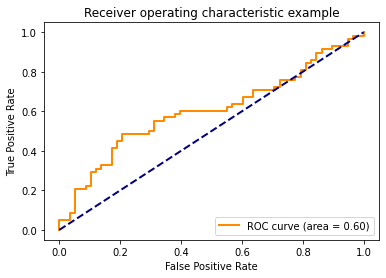

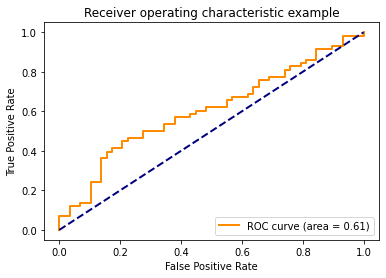

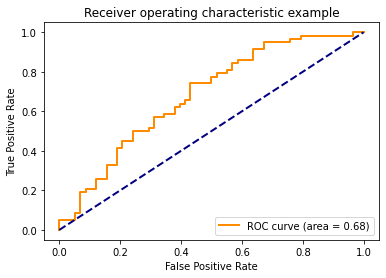

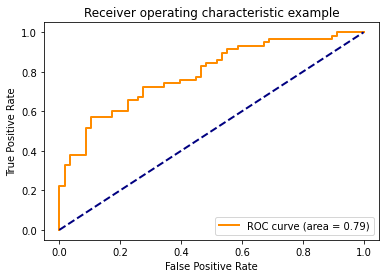

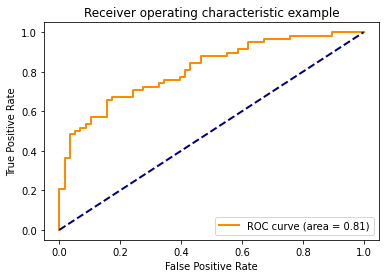

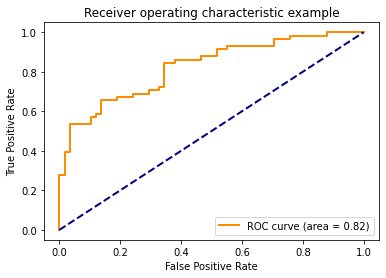

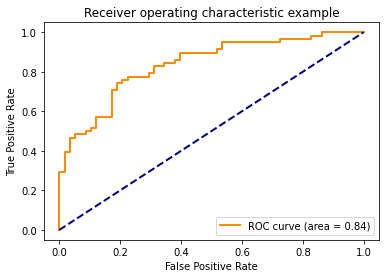

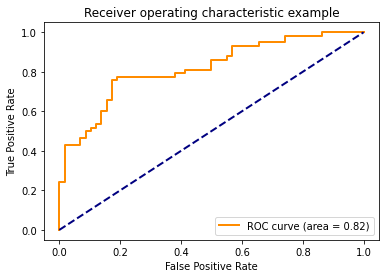

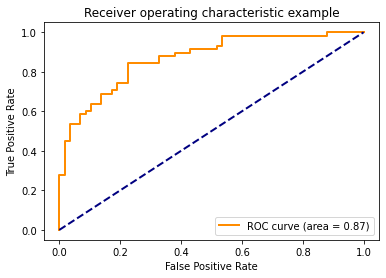

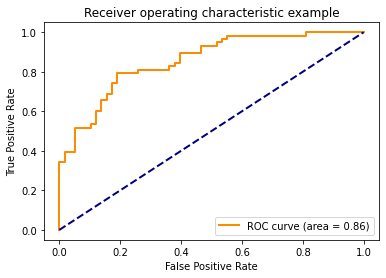

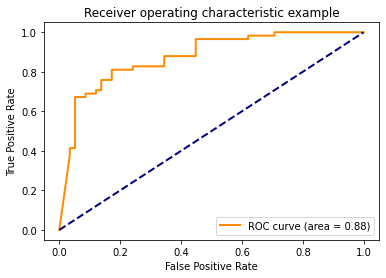

In [21]:
##########
# Usage
#   python train_grav.py
##########
# ├─gravcont_250px
# │   ├─train
# │   │  ├─cont
# │   │  └─grav
# │   └─val
# │       ├─cont
# │       └─grav
# ├──train_grav.py
# └──evaluator_grav.py

import os
import random
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from efficientnet_pytorch import EfficientNet 

# change working directory
path = '/content/drive/MyDrive/Deep_learning/666mai_dataset'
os.chdir(path)

# grav or cont
NUM_CLASSES = 2
# contains train, val
DATASET_PATH = r"./crossvalidation_250px/0/"
TEST_PATH = r"./crossvalidation_250px/test/"
TRAIN_FOLDER_NAME = "train"
VAL_FOLDER_NAME = "val"
EFFICIENT_NET_NAME = "efficientnet-b0"
MODEL_PATH = "./model.pth"
OPTIMIZER_PATH = "./optimizer.pth"
LOG_PATH = "./log.txt"
ROC_PATH = "./roc.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
BATCH_SIZE = 16

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
VAL_CROP_SCALE =(0.75,1.0)

#######
# Set random seem for reproducibility
manualSeed = 1234
# print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
#######

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_dataloader(root, name, transform, batch_size=BATCH_SIZE, shuffle=True):
        dataset = datasets.ImageFolder(os.path.join(root,name), transform=transform)
        dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
        print(name + "_dataset_size："+str(len(dataset)))
        return dataloader
        
if __name__ == "__main__":
        if os.path.exists(MODEL_PATH):
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, MODEL_PATH, num_classes=NUM_CLASSES)
        else:
                model = EfficientNet.from_pretrained(EFFICIENT_NET_NAME, num_classes=NUM_CLASSES)
        model.train()
        model.to(device)

        # transforms自体を定数として上に記述しても良いかもしれません
        train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM,
                 saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
        val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])                
        train_dataloader = get_dataloader(DATASET_PATH, TRAIN_FOLDER_NAME, train_data_transforms)

        optimizer = torch.optim.AdamW(model.parameters(), 0.0002)
        if os.path.exists(OPTIMIZER_PATH):
                optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))

        loss_func = torch.nn.CrossEntropyLoss()

        val_folder_path = os.path.join(DATASET_PATH, VAL_FOLDER_NAME)
        evaluator = Evaluator(model, train_dataloader.dataset.classes, val_folder_path, val_data_transforms, device)
        evaluator.draw_roc(ROC_PATH)

        for epoch in range(EPOCH):
                for (i, batch) in enumerate(train_dataloader):
                        optimizer.zero_grad()

                        inputs, labels = batch
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = model(inputs)

                        loss = loss_func(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        if i % CHECKPOINT_COUNT == 0:
                                is_best, score = evaluator.evaluate()
                                if is_best:
                                        evaluator.draw_roc(ROC_PATH)
                                        torch.save(model.state_dict(), MODEL_PATH)
                                        torch.save(optimizer.state_dict(), OPTIMIZER_PATH)

                                # write log to file
                                with open(LOG_PATH, 'a') as f:
                                        f.write("-----")
                                        f.write("\n")
                                        f.write("batch_size: " + str(BATCH_SIZE))
                                        f.write("\n")
                                        f.write("iter: " + str(epoch * len(train_dataloader) + i))
                                        f.write(str(score))
                                        f.write("\n")

                                # print log
                                print("-----")
                                print(score)
                                print("max_accuracy: " + str(evaluator.max_accuracy))

eval number of classes: 2
eval number of images: 86
initial accuracy: 0.1511627906976744
(0.15, 0.11, 0.09, 0.21, 0.1)


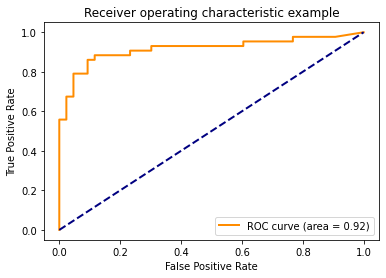

In [24]:
        #ここからevaluation (accuracy, precision, recall, specificity, f_value)                        
        model.eval()

        test_dataset = SimpleImageDataset(TEST_PATH, val_data_transforms)
        test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        test_folder_path = TEST_PATH
        evaluator = Evaluator(model, test_dataset.class_names, test_folder_path, val_data_transforms, device)
        
        _ ,score =evaluator.evaluate()
        print(score)

        evaluator.draw_roc(ROC_PATH)